# Identify population-enriched genes in injury condition. Show the expression of the same genes in counterpart populations in control condition.

In [1]:
import os,sys
import datetime

### Import scanpy

In [2]:
import scanpy.api as sc
sc.logging.print_versions()
sc.logging.print_memory_usage()
sc.settings.verbosity = 2

scanpy==1.3.4 anndata==0.6.13 numpy==1.15.4 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.20.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 
Memory usage: current 0.17 GB, difference +0.17 GB


### Import my utility functions and import statements from github

In [3]:
"""# This cell is run once to download my custom functions and import statements from github

!git clone --depth=1 https://github.com/rapolaszilionis/utility_functions
    
# github doesn't seem to have an option to download a specific version of the repo from the history.
# So I download my utility functions and save the download time by appending it to the directory name.
# These utility functions to be shared together with the notebook.

toappend = datetime.datetime.now().strftime('%y%m%d_%Hh%M')
newname = "utility_functions_%s"%toappend
print(newname)


# rename the py file with utility functions
os.rename("utility_functions",newname)"""

'# This cell is run once to download my custom functions and import statements from github\n\n!git clone --depth=1 https://github.com/rapolaszilionis/utility_functions\n    \n# github doesn\'t seem to have an option to download a specific version of the repo from the history.\n# So I download my utility functions and save the download time by appending it to the directory name.\n# These utility functions to be shared together with the notebook.\n\ntoappend = datetime.datetime.now().strftime(\'%y%m%d_%Hh%M\')\nnewname = "utility_functions_%s"%toappend\nprint(newname)\n\n\n# rename the py file with utility functions\nos.rename("utility_functions",newname)'

In [4]:
# add the utility function folder to PATH
sys.path.append(os.path.abspath("utility_functions_190425_11h32"))

from rz_import_statements import *
import rz_functions as rz
import rz_fig_params # this adjust mpl.rcParams, almost nothing to import
import rz_utility_spring as srz

python version: 3.6.7


# Load data and place into an annData object

In [5]:
!ls data_from_geo

cell_info_8594x25.tsv         injury_barcodes.tsv
control_barcodes.tsv          injury_genes.tsv
control_genes.tsv             injury_loom.loom
control_loom.loom             injury_matrix.mtx
control_matrix.mtx            raw_counts_8594x27998.mtx
gene_names_alphabetically.txt


In [6]:
obspath = 'data_from_geo/cell_info_8594x25.tsv'
countpath = 'data_from_geo/raw_counts_8594x27998.mtx'
genepath = 'data_from_geo/gene_names_alphabetically.txt'

In [7]:
# load cell info
obs = pd.read_csv(obspath,sep='\t',index_col=0)
print(obs.shape)
obs.head()

(8594, 25)


,barcode,condition,total_counts,pass_quality_filters,inj_epithelial,ctr_epithelial,excluded_as_immune_or_mesench,class,population,phase,...,x_control,y_control,x_class3_exploded,y_class3_exploded,x_control_injured,y_control_injured,x_class1_CTR_cell_cyc_removed,y_class1_CTR_cell_cyc_removed,x_class1_INJ_cell_cyc_removed,y_class1_INJ_cell_cyc_removed
0,AAACCTGAGTGCTGCC-1,control,2787,True,False,True,False,class3,ctr_DEEx,G1,...,783.705500,-377.074709,1082.172898,-266.303304,709.78614,-325.505019,NaN,NaN,NaN,NaN
1,AAACCTGAGTGGGTTG-1,control,3325,True,False,True,False,class3,ctr_upper_IEE,G1,...,709.612642,-429.409941,854.230866,-454.025809,529.15516,-471.961493,NaN,NaN,NaN,NaN
2,AAACCTGCAAGTCTAC-1,control,1781,False,False,False,False,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAACCTGCAATCTGCA-1,control,3468,True,False,False,True,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAACCTGCACGGTGTC-1,control,1745,False,False,False,False,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# load counts
adata = sc.read_mtx(countpath)
print(adata.shape)

# add genes (annotation of variables)
adata.var['genes'] = np.loadtxt(genepath,dtype=str)

# make sure var names are genes
adata.var_names = adata.var['genes'].values

# add obs (annotation of observations)
adata.obs = obs

# make sure index is unique AND a string
adata.obs_names_make_unique()
adata.obs_names = adata.obs_names.astype(str)

(8594, 27998)


### Scale (normalize) data

In [9]:
# turn into counts per 10k
print(adata.X[:5,:].sum(axis=1))
print()
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
print(adata.X[:5,:].sum(axis=1))

[[2787.]
 [3325.]
 [1781.]
 [3468.]
 [1745.]]

[[10000.   ]
 [10000.   ]
 [10000.001]
 [10000.   ]
 [ 9999.999]]


### Functions

In [10]:
# I should move this function to rz_functions.py eventually
def get_fc_to_all_other(
    lab,
    meta,
    E,
    pseudo,
    gene_list,
    print_progression = False,
    ):
    
    """
    For each cluster i, find fold-change of a gene in i vs all other cells.
    
    input:
        lab - meta column name to group cell by
        meta - meta dataframe, cells x features
        E - sparse counts, cells x genes, same nr cells as meta
        pseudo - pseudovalue to add
        gene_list - gene list, matches the nr columns of E
        
    output:
        dictionary with cluster names as keys, and pd.Series of genes
        and their fold-change in cluster vs all other cells/
    
    example of use:
        
        
        fcdict = get_fc_to_all_other(
        lab = thelabel,
        meta = meta[cellmask_to_use],
        E = Enorm[cellmask_to_use,:],
        pseudo = pseudo,
        gene_list = gene_list
        )
    
    
    """
    
    resdict = {}
    
    for cl in meta[lab].unique():
        mask = (meta[lab] == cl).values
        maskinv = ~mask

        # selected cells
        left = np.array(E[mask,:].todense())

        # all other cells
        right = np.array(E[maskinv,:].todense())

        # fold-change
        fc = pd.Series((left.mean(axis=0)+pseudo)/(right.mean(axis=0)+pseudo),index=gene_list)
        resdict[cl] = fc
        
        if print_progression:
            print(cl)

    return resdict

# rename for easy code recycling once I move
# the function to 
rz.get_fc_to_all_other = get_fc_to_all_other
del get_fc_to_all_other

### Mkdir for outputs

In [12]:
outdir = 'outputs/gene_expression_similarities_in_same_population_ctrl_vs_injury/'
#!mkdir -p $outdir

# Get of enriched genes

In [13]:
cmask = adata.obs['inj_epithelial'].astype(bool).values
print(cmask.sum(),len(cmask))

4344 8594


In [14]:
thelabel = 'population'

In [15]:
# cell count per label
ccount = adata[cmask].obs.groupby(thelabel).count().iloc[:,0]
ccount

population
inj_AMB_dist        3
inj_AMB_prox        2
inj_DEEx          395
inj_G2_M          466
inj_ISR_SI        167
inj_M_G1         1358
inj_OEE_1          31
inj_OEE_2         611
inj_OEE_IEE       141
inj_OSR           233
inj_S             658
inj_SI             47
inj_VEE           157
inj_pre_AMB        53
inj_upper_IEE      22
Name: barcode, dtype: int64

In [16]:
# let's omit those labels that have fewer than 3 cells
m = ccount<3
toomit = m.index[m]
print(toomit)

Index(['inj_AMB_prox'], dtype='object', name='population')


In [17]:
# update cmask
cmask = cmask&(~adata.obs[thelabel].isin(toomit).values)

In [18]:
# get centroids
centroids = rz.centroids(thelabel,adata[cmask])

In [19]:
# For each cluster, find genes that are statistically significantly higher or lower in cluster x compared to
# all other cells collectively

#label-free filter to remove very low abundance genes:
min_counts = 6
min_cells = 3

In [20]:
gmask = srz.filter_abund_genes(adata.X[cmask], min_counts, min_cells)

7975 genes passing abundance filter


In [21]:
mwu_dict = {}
start=time.time()
counter=0

meta = adata[cmask].obs
E = adata[cmask].X
gene_list = adata.var_names


for cluster in meta[thelabel].unique():
    counter+=1
    mask1 = (meta[thelabel]==cluster).values
    mask2 = mask1==False
    
    cg1 = np.array(E[:,gmask][mask1,:].todense())
    cg2 = np.array(E[:,gmask][mask2,:].todense())
    mwu_dict[cluster] = rz.mwu(cg1,cg2,genes=gene_list[gmask],print_progression=True)
    print("%d/%d"%(counter,len(meta[thelabel].unique())))
    print(cluster, 'done',cg1.shape[0]+cg2.shape[0])
print(time.time()-start)

fname = 'backups/cluster_vs_rest_MWU_result_dict_%s'%rz.now()
print(fname)
#rz.save_stuff(mwu_dict,fname)

1000
2000
3000
4000
5000
6000
7000
1/14
inj_M_G1 done 4342
1000
2000
3000
4000
5000
6000
7000
2/14
inj_SI done 4342
1000
2000
3000
4000
5000
6000
7000
3/14
inj_G2_M done 4342
1000
2000
3000
4000
5000
6000
7000
4/14
inj_OEE_2 done 4342
1000
2000
3000
4000
5000
6000
7000
5/14
inj_S done 4342
1000
2000
3000
4000
5000
6000
7000
6/14
inj_ISR_SI done 4342
1000
2000
3000
4000
5000
6000
7000
7/14
inj_OEE_IEE done 4342
1000
2000
3000
4000
5000
6000
7000
8/14
inj_OSR done 4342
1000
2000
3000
4000
5000
6000
7000
9/14
inj_DEEx done 4342
1000
2000
3000
4000
5000
6000
7000
10/14
inj_OEE_1 done 4342
1000
2000
3000
4000
5000
6000
7000
11/14
inj_upper_IEE done 4342
1000
2000
3000
4000
5000
6000
7000
12/14
inj_VEE done 4342
1000
2000
3000
4000
5000
6000
7000
13/14
inj_pre_AMB done 4342
1000
2000
3000
4000
5000
6000
7000
14/14
inj_AMB_dist done 4342
72.59236693382263
backups/cluster_vs_rest_MWU_result_dict_190428_16h16


In [48]:
# if continuing from backup
#mwu_dict = rz.load_stuff('backups/cluster_vs_rest_MWU_result_dict_190428_16h16.pickle')

In [22]:
# select pseudovalue to add
pseudo = 1 # 1 counts per 10k

In [23]:
print(thelabel)
fcdict = rz.get_fc_to_all_other(
        lab = thelabel,
        meta = adata[cmask].obs,
        E = adata[cmask].X,
        pseudo = pseudo,
        gene_list = adata.var_names,
        )

population


In [25]:
# leave only genes with a significant difference.
fcdictsig = {}

# before the mwu test, I prefiltered genes on abundance, apply this mask here as well
print(gmask.sum())
for key,value in fcdict.items():
    sigmask = (mwu_dict[key]['fdr']<0.05).values
    fcdictsig[key] = value[gmask][sigmask]
    print(key,sigmask.sum(),len(fcdictsig[key]))

7975
inj_M_G1 4720 4720
inj_SI 420 420
inj_G2_M 3768 3768
inj_OEE_2 5977 5977
inj_S 5330 5330
inj_ISR_SI 2563 2563
inj_OEE_IEE 2994 2994
inj_OSR 3491 3491
inj_DEEx 3663 3663
inj_OEE_1 362 362
inj_upper_IEE 45 45
inj_VEE 3044 3044
inj_pre_AMB 619 619
inj_AMB_dist 87 87


In [26]:
# nr genes to consider:
upto = 20

frame = {}
for key,value in fcdictsig.items():
    if key in toomit:
        continue
    s = value.sort_values(ascending=False)[:upto]
    key2 = str(key)+'_FC'
    frame[str(key)] = s.index
    frame[key2] = s.values
frame = pd.DataFrame(frame)
frame[[i for i in frame.columns if "FC" in i]].min() #ok, all above 1.

inj_M_G1_FC         1.515313
inj_SI_FC           2.491914
inj_G2_M_FC         2.928829
inj_OEE_2_FC        2.311628
inj_S_FC            1.843412
inj_ISR_SI_FC       2.215254
inj_OEE_IEE_FC      2.621457
inj_OSR_FC          2.336737
inj_DEEx_FC         1.561031
inj_OEE_1_FC        2.498938
inj_upper_IEE_FC    1.440597
inj_VEE_FC          2.736321
inj_pre_AMB_FC      2.471000
inj_AMB_dist_FC     3.887258
dtype: float32

In [27]:
fname = outdir+'lists_enriched_genes_top_%d_%s_%s.xlsx'%(
    upto,thelabel,rz.now())
print(fname)
#frame.to_excel(fname)

outputs/gene_expression_similarities_in_same_population_ctrl_vs_injury/lists_enriched_genes_top_20_population_190428_16h17.xlsx


In [28]:
# order of population used in Fig1
fig1corder = [
'ctr_AMB_dist',
'ctr_AMB_prox',
'ctr_pre_AMB',
'ctr_DEEx',
'ctr_upper_IEE',
'ctr_OEE_IEE',
'ctr_S',
'ctr_M_G1',
'ctr_G2_M',
'ctr_SI',
'ctr_OSR',
'ctr_ISR_SI',
'ctr_OEE_1',
'ctr_VEE',
'ctr_OEE_2'
]

In [33]:
clnames = list(fcdictsig.keys())
#order as in fig1:
clnames = [i.replace('ctr_','inj_') for i in fig1corder][::-1]
clnames = [i for i in clnames if i in frame.columns]
clnames

['inj_OEE_2',
 'inj_VEE',
 'inj_OEE_1',
 'inj_ISR_SI',
 'inj_OSR',
 'inj_SI',
 'inj_G2_M',
 'inj_M_G1',
 'inj_S',
 'inj_OEE_IEE',
 'inj_upper_IEE',
 'inj_DEEx',
 'inj_pre_AMB',
 'inj_AMB_dist']

In [34]:
# select only columns with gene names:
genes = frame[clnames[::-1]].values.T.flatten()
print(len(genes))

# I anticipate some genes to be repeated
genes = rz.oset(genes)
print(len(genes))

# select centroids expression data
heat = centroids.loc[clnames,genes].copy()

# transform:
heat = heat + pseudo

# normalize to median
heat = heat/heat.median()

#log
heat = np.log2(heat)

#transpose
heat = heat.T

# order as to maximise the red on the diagonal:
tmp = heat.copy()
tmp['ixmax'] = tmp.idxmax(axis=1)
tmp['max'] = tmp.max(axis=1)
tmp = tmp.sort_values(['ixmax','max'],ascending=False)
gorder = [tmp.index[pop==tmp['ixmax']] for pop in clnames[::-1]]
gorder = rz.flatten_list_of_lists(gorder)

heat = heat.loc[gorder,clnames]

280
213


### Heatmap

In [35]:
totick = ['']

-2.6378992 10.817421
injury_enriched_heatmap_population_upto_20_190428_16h21


/Users/rapolaszilionis/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


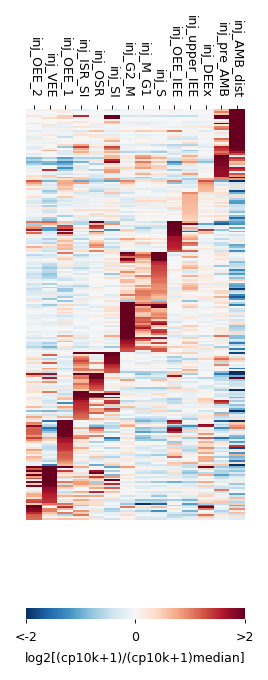

In [36]:
a,fig,gs = rz.startfig(4.5,12,frameon=False)

cmap = 'RdBu_r'
cbarlabel = 'log2[(cp10k+1)/(cp10k+1)median]'

vmin=-2
vmax=2

print(heat.min().min(),heat.max().max())

# heatmap
hmap = a.imshow(heat,aspect='auto',vmin=vmin,vmax=vmax,cmap=cmap)

# x ticks
a.set_xticks(np.arange(heat.shape[1]))
a.set_xticklabels(heat.columns,rotation=270)
a.xaxis.tick_top()

# y ticks
rz.yticks_fancy(a,totick,labels_all = heat.index)

# colorbar
cbar = fig.colorbar(hmap,orientation='horizontal')
cbar.outline.set_visible(False)

c = [vmin,0,vmax]
clabs = ["<"+str(c[0])]+[str(i) for i in c[1:-1]]+[">"+str(c[-1])]
cbar.set_ticks(c)
cbar.set_ticklabels(clabs)
cbar.set_label(cbarlabel)


gs.tight_layout(fig)
fname = 'injury_enriched_heatmap_%s_upto_%d_%s'%(thelabel,upto,rz.now())
print(fname)
#plt.savefig(outdir+'%s.pdf'%fname,dpi=600)

In [37]:
# save the pandas dataframe colored as in the heatmap to excel
rz.color_dataframe_cells(heat,vmin=vmin,vmax=vmax,cmap=mpl.cm.get_cmap('RdBu_r'))#.to_excel(outdir+'%s.xlsx'%fname)

# Check the expression of same genes in counterpart populations in control

In [38]:
hits = heat.index

In [39]:
thelabel_all = 'population'

cmask_all = adata.obs['ctr_epithelial'].astype(bool).values
centroids_all = rz.centroids(thelabel_all,adata[cmask_all])

In [40]:
# select only columns with gene names:
genes = hits
print(len(genes))

thecols = centroids_all.index

# select centroids expression data
heat = centroids_all.loc[thecols,genes].copy()

# transform:
heat = heat + pseudo

# normalize to median
heat = heat/heat.median()

# log
heat = np.log2(heat)

#transpose
heat = heat.T

# here either order as in fig1
corder = [i for i in fig1corder if i in heat.columns][::-1]
comment = 'FIG1_ORDER'

# reorder
heat = heat[corder]

213


-2.431777 7.691111
control_heatmap_population_upto_20_190428_16h22_FIG1_ORDER


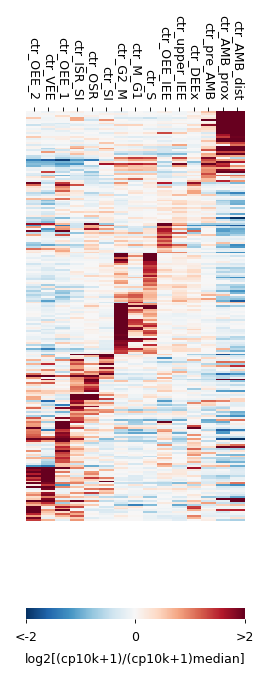

In [41]:
a,fig,gs = rz.startfig(4.5,12,frameon=False)

cmap = 'RdBu_r'
cbarlabel = 'log2[(cp10k+1)/(cp10k+1)median]'

vmin=-2
vmax=2

print(heat.min().min(),heat.max().max())

# heatmap
hmap = a.imshow(heat,aspect='auto',vmin=vmin,vmax=vmax,cmap=cmap)

# x ticks
a.set_xticks(np.arange(heat.shape[1]))
a.set_xticklabels(heat.columns,rotation=270)
a.xaxis.tick_top()

# y ticks
rz.yticks_fancy(a,totick,labels_all = heat.index)

# colorbar
cbar = fig.colorbar(hmap,orientation='horizontal')
cbar.outline.set_visible(False)

c = [vmin,0,vmax]
clabs = ["<"+str(c[0])]+[str(i) for i in c[1:-1]]+[">"+str(c[-1])]
cbar.set_ticks(c)
cbar.set_ticklabels(clabs)
cbar.set_label(cbarlabel)


gs.tight_layout(fig)
fname = 'control_heatmap_%s_upto_%d_%s_%s'%(thelabel,upto,rz.now(),comment)
print(fname)
#plt.savefig(outdir+'%s.pdf'%fname,dpi=600)

In [42]:
# save the pandas dataframe colored as in the heatmap to excel
rz.color_dataframe_cells(heat,vmin=vmin,vmax=vmax,cmap=mpl.cm.get_cmap('RdBu_r'))#.to_excel(outdir+'%s.xlsx'%fname)